# Set-up environment

In [1]:
# !pip install torch torchvision torchaudio pillow matplotlib pandas
!pip install --upgrade transformers accelerate peft datasets bitsandbytes evaluate
# !pip install git+https://github.com/salaniz/pycocoevalcap
!pip install pycocoevalcap
# !pip install pycocotools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found

In [2]:
import os
import pandas as pd
import torch
from transformers import BitsAndBytesConfig, AutoProcessor, Blip2ForConditionalGeneration
from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datasets import load_dataset
# import torch.optim
from evaluate import load
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from matplotlib import pyplot as plt

# nuScenes dataset

In [3]:
!mkdir -p /content/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /content/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

--2024-12-09 15:59:31--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 18.238.136.63, 18.238.136.12, 18.238.136.129, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|18.238.136.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G   358MB/s    in 12s     

2024-12-09 15:59:43 (344 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



In [4]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes

dataroot = '/content/nuscenes'
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.692 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [5]:
data = []

for sample in nusc.sample:
  scene = nusc.get("scene", sample["scene_token"])
  scene_description = scene["description"]
  description = f"a photo of {scene_description[0].lower() + scene_description[1:]}"

  cam_data = sample['data'].get('CAM_FRONT', None)

  img_path = os.path.join(dataroot, nusc.get('sample_data', cam_data)['filename'])

  data.append({"image_path": img_path, "description": description})

df = pd.DataFrame(data)
csv_path = '/content/nuscenes/dataset.csv'
df.to_csv(csv_path, index=False)
print(f"Dataset saved to {csv_path}")
print(df.head())

Dataset saved to /content/nuscenes/dataset.csv
                                          image_path  \
0  /content/nuscenes/samples/CAM_FRONT/n015-2018-...   
1  /content/nuscenes/samples/CAM_FRONT/n015-2018-...   
2  /content/nuscenes/samples/CAM_FRONT/n015-2018-...   
3  /content/nuscenes/samples/CAM_FRONT/n015-2018-...   
4  /content/nuscenes/samples/CAM_FRONT/n015-2018-...   

                                         description  
0  a photo of parked truck, construction, interse...  
1  a photo of parked truck, construction, interse...  
2  a photo of parked truck, construction, interse...  
3  a photo of parked truck, construction, interse...  
4  a photo of parked truck, construction, interse...  


In [6]:
quant_config = BitsAndBytesConfig(load_in_8bit=True)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", quantization_config=quant_config, device_map="auto")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [7]:
class ImageCaptioningDataset(Dataset):
  def __init__(self, dataset, processor, max_length=32):
    self.dataset = dataset
    self.processor = processor
    self.max_length = max_length

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]

    image = Image.open(item["image_path"]).convert("RGB")

    encoding = self.processor(
        images=image,
        text=item["description"],
        padding="max_length",
        truncation=True,
        max_length=self.max_length,
        return_tensors="pt"
    )

    encoding = {k: v.squeeze(0) for k, v in encoding.items()}
    return encoding

def collate_fn(batch):
  pixel_values = torch.stack([example["pixel_values"] for example in batch], dim=0)
  input_ids = torch.stack([example["input_ids"] for example in batch], dim=0)
  attention_mask = torch.stack([example["attention_mask"] for example in batch], dim=0)

  return {"pixel_values": pixel_values, "input_ids": input_ids, "attention_mask": attention_mask}

In [8]:
dataset = load_dataset("csv", data_files=csv_path)
dataset = dataset["train"].train_test_split(test_size=0.2)

train_dataset = ImageCaptioningDataset(dataset["train"], processor, max_length=32)
test_dataset = ImageCaptioningDataset(dataset["test"], processor, max_length=32)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

for batch in train_dataloader:
  pixel_values = batch["pixel_values"]
  input_ids = batch["input_ids"]
  attention_mask = batch["attention_mask"]
  print(pixel_values.shape, input_ids.shape, attention_mask.shape)
  break

for batch in test_dataloader:
  pixel_vales = batch["pixel_values"]
  input_ids = batch["input_ids"]
  attention_mask = batch["attention_mask"]
  print(pixel_values.shape, input_ids.shape, attention_mask.shape)
  break

Generating train split: 0 examples [00:00, ? examples/s]

torch.Size([8, 3, 224, 224]) torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 3, 224, 224]) torch.Size([8, 64]) torch.Size([8, 64])


In [9]:
# class COCODataset(Dataset):
#   def __init__(self, coco, processor, max_length=32):
#     self.coco = coco
#     self.processor = processor
#     self.max_length = max_length

#   def __len__(self):
#     return len(self.coco)

#   def __getitem__(self, idx):
#     item = self.coco[idx]
#     image = item["image"]
#     captions = item["captions"]

#     encoding = self.processor(
#         images=image,
#         text=captions,
#         padding="max_length",
#         truncation=True,
#         max_length=self.max_length,
#         return_tensors="pt"
#     )

#     encoding = {k: v.squeeze(0) for k, v in encoding.items()}
#     return {"pixel_values": encoding["pixel_values"], "input_ids": encoding["input_ids"], "captions": captions}

In [ ]:
# coco = load_dataset("coco_captions", split="validation")
# print(coco[0])

In [11]:
# coco_dataset = COCODataset(coco, processor)
# coco_dataloader = DataLoader(coco_dataset, batch_size=8, shuffle=False)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def generate_captions(model, dataloader, processor, device):
  generated_captions = []
  references = []

  for batch in dataloader:
    pixel_values = batch["pixel_values"].to(device, torch.float16)

    input_ids = batch["input_ids"]

    with torch.no_grad():
      generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=25)
      captions = processor.batch_decode(generated_ids, skip_special_tokens=True)

    references_batch = processor.batch_decode(input_ids, skip_special_tokens=True)

    generated_captions.extend(captions)
    references.extend(references_batch)

  return generated_captions, references

def calculate_cider(predictions, references):
  gts = {i: [ref] for i, ref in enumerate(references)}
  res = {i: [pred] for i, pred in enumerate(predictions)}

  cider_scorer = Cider()
  cider_score, _ = cider_scorer.compute_score(gts, res)
  return cider_score

def calculate_spice(predictions, references):
  gts = {i: [ref] for i, ref in enumerate(references)}
  res = {i: [pred] for i, pred in enumerate(predictions)}

  spice_scorer = Spice()
  spice_score, _ = spice_scorer.compute_score(gts, res)
  return spice_score

def evaluate_performance(predictions, references):
  cider_score = calculate_cider(predictions, references)
  spice_score = calculate_spice(predictions, references)

  return cider_score, spice_score

def evaluate_model(model, dataloader, processor, device):
  model.eval()
  with torch.no_grad():
    generated_captions, references = generate_captions(model, dataloader, processor, device)
  cider, spice = evaluate_performance(generated_captions, references)
  return cider, spice

In [13]:
pretrained_cider, pretrained_spice = evaluate_model(model, test_dataloader, processor, device)
print(f"Pretrained Model - CIDEr: {pretrained_cider:.4f}, SPICE: {pretrained_spice:.4f}")

Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
Pretrained Model - CIDEr: 0.0460, SPICE: 0.0825


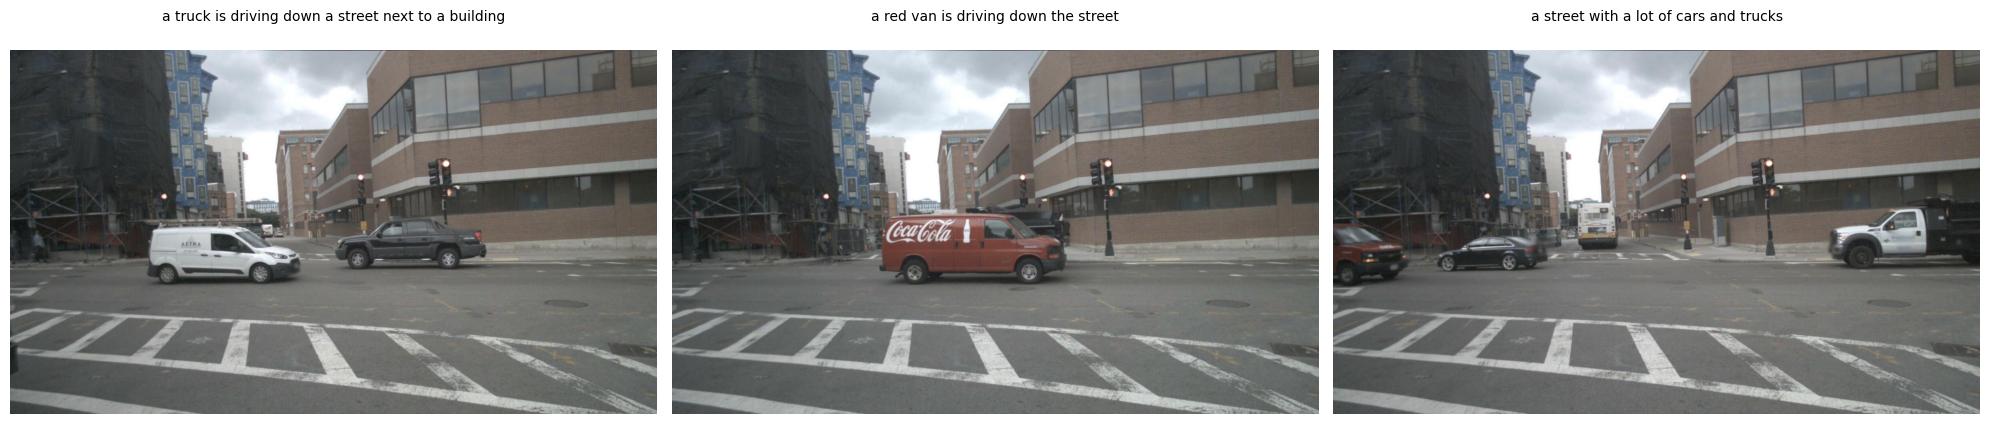

In [14]:
fig = plt.figure(figsize=(20, 15))
num_samples = 3

for i, example in enumerate(dataset["test"]):
  if i >= num_samples:
    break

  image_path = example["image_path"]
  image = Image.open(image_path).convert("RGB")

  inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=25)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  fig.add_subplot(1, num_samples, i + 1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"{generated_caption}", fontsize=10, pad=10)

plt.tight_layout()
plt.show()

In [15]:
# coco_cider, coco_spice = evaluate_model(model, coco_dataloader, processor, device)
# print(f"COCO Dataset - CIDEr: {coco_cider:.4f}, SPICE: {coco_spice:.4f}")

# Training

In [16]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,750,004,736 || trainable%: 0.1398


In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

model.train()

for epoch in range(30):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss
    print("Loss:", loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # torch.save(model.state_dict(), f"model_epoch_{epoch}.pt")

Epoch: 0
Loss: 11.3125
Loss: 11.046875
Loss: 10.671875
Loss: 10.453125
Loss: 9.8125
Loss: 9.1171875
Loss: 8.234375
Loss: 7.515625
Loss: 6.796875
Loss: 5.84375
Loss: 5.23828125
Loss: 5.0
Loss: 4.75390625
Loss: 4.4609375
Loss: 4.43359375
Loss: 4.2109375
Loss: 3.919921875
Loss: 3.74609375
Loss: 3.51171875
Loss: 3.369140625
Loss: 3.37890625
Loss: 3.185546875
Loss: 2.970703125
Loss: 3.0078125
Loss: 2.79296875
Loss: 2.595703125
Loss: 2.5703125
Loss: 2.400390625
Loss: 2.25390625
Loss: 2.2421875
Loss: 2.095703125
Loss: 2.1640625
Loss: 2.072265625
Loss: 1.947265625
Loss: 1.8310546875
Loss: 1.7900390625
Loss: 1.77734375
Loss: 1.8681640625
Loss: 1.611328125
Loss: 1.6337890625
Loss: 1.8798828125
Epoch: 1
Loss: 1.6240234375
Loss: 1.6044921875
Loss: 1.43359375
Loss: 1.5283203125
Loss: 1.466796875
Loss: 1.43359375
Loss: 1.3466796875
Loss: 1.35546875
Loss: 1.39453125
Loss: 1.1982421875
Loss: 1.3447265625
Loss: 1.1982421875
Loss: 1.19921875
Loss: 1.2314453125
Loss: 1.19921875
Loss: 1.10546875
Loss: 1.1

In [18]:
trained_cider, trained_spice = evaluate_model(model, test_dataloader, processor, device)
print(f"Trained Model - CIDEr: {trained_cider:.4f}, SPICE: {trained_spice:.4f}")

Trained Model - CIDEr: 9.4472, SPICE: 0.9648


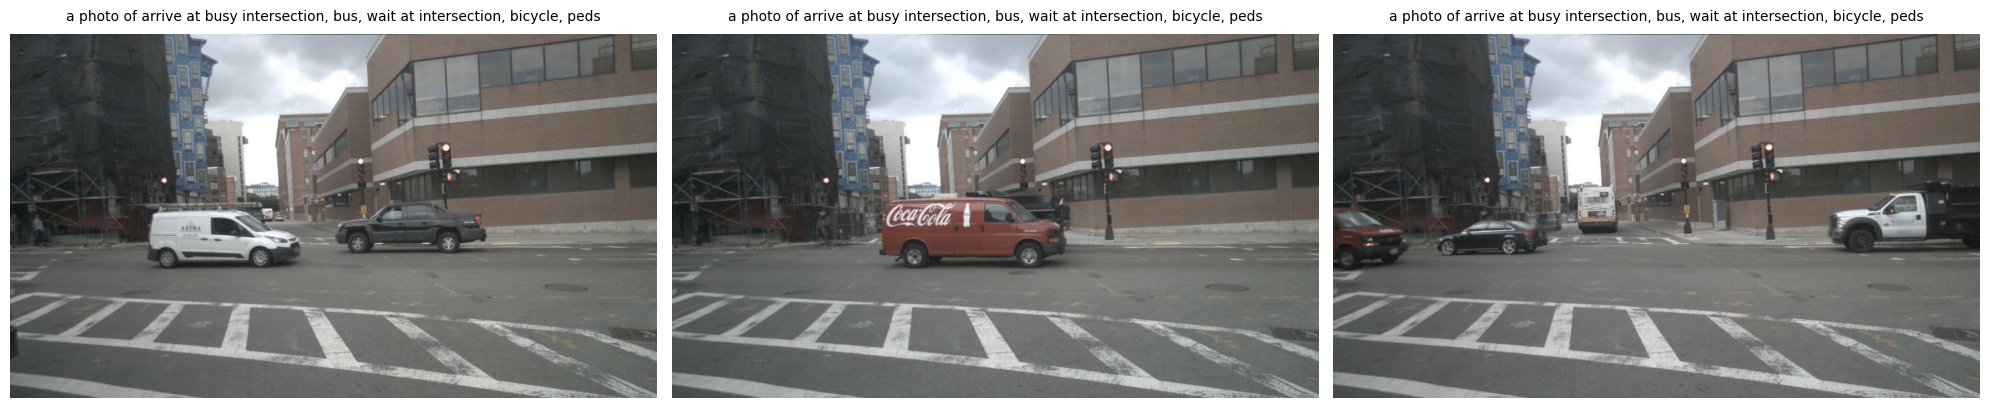

In [20]:
fig = plt.figure(figsize=(20, 15))
num_samples = 3

for i, example in enumerate(dataset["test"]):
  if i >= num_samples:
    break

  image_path = example["image_path"]
  image = Image.open(image_path).convert("RGB")

  inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=25)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

  fig.add_subplot(1, num_samples, i + 1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"{generated_caption}", fontsize=10, pad=10)

plt.tight_layout()
plt.show()